In [ ]:
import random

population_size = 100    # Tamanho arbitrário da população
generations = 10000        # Número arbitrário de gerações
mutation_rate = 0.05         # Taxa de mutação arbitraria
num_items = 100             # Os N itens
knapsack_capacity = 100     # A capacidade W
convergence_threshold = 100

In [ ]:
# Generate random items with random weights and values
items = []
for _ in range(num_items):
    weight = random.randint(1, 50)  # Pesos aleatórios entre 1 e 50
    value = random.randint(1, 1000)  # Lucro aleatório entre 1 and 1000
    items.append({"weight": weight, "value": value})

In [ ]:
# Inicialização a população de forma aleatória
def initialize_population(pop_size):
    population = []
    while len(population) < pop_size:
        # Gerando individuos com um peso menor do que o máximo da bolsa
        individual = [0] * num_items
        cumulative_weight = 0
        while cumulative_weight <= knapsack_capacity:
            index = random.randint(0, num_items - 1)
            if individual[index] == 0:
                individual[index] = 1
                cumulative_weight += items[index]["weight"]
        # Ajustando caso o indivíduo ultrapasse o limite
        if cumulative_weight > knapsack_capacity:
            individual[index] = 0
            cumulative_weight -= items[index]["weight"]
        population.append(individual)

    return population

In [ ]:
def calculate_total_weight(solution):
    total_weight = sum(items[i]["weight"] * solution[i] for i in range(len(solution)))
    return total_weight

In [ ]:
def calculate_total_value(solution):
    total_value = sum(items[i]["value"] * solution[i] for i in range(len(solution)))
    return total_value

In [ ]:
# Calculando o fitness
def calculate_fitness(solution):
    total_weight = 0
    total_value = 0
    for i in range(len(solution)):
        if solution[i] == 1:
            total_weight += items[i]["weight"]
            total_value += items[i]["value"]

    if total_weight > knapsack_capacity:
        return 0  # Extrapolou o limite (talvez no futuro, alterar para uma penalidade e não zerar)

    else:
        return total_value # Retornando o ratio entre peso e lucro

In [ ]:
def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    roulette_value = random.uniform(0.0, total_fitness)

    cumulative_fitness = 0
    selected_parent = None

    for individual, fitness in zip(population, fitness_values):
        cumulative_fitness += fitness
        if cumulative_fitness >= roulette_value:
            selected_parent = individual
            break

    return selected_parent

In [ ]:
# One-point crossover
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [ ]:
#  Mutando
def mutate(solution, mutation_rate):
    for i in range(len(solution)):
        if random.random() < mutation_rate:
            solution[i] = 1 - solution[i]
    return solution

In [ ]:
#  Trocando 50% da população a cada geração
def steady_state_replacement(old_population, new_offspring):
    combined_population = old_population + new_offspring
    combined_population.sort(key=lambda x: calculate_fitness(x), reverse=True)

    new_population = combined_population[:len(old_population) // 2] + new_offspring
    return new_population

In [ ]:
# Genetic algorithm
def genetic_algorithm(pop_size, generations, mutation_rate):
    population = initialize_population(pop_size)
    fitness_values = [0]
    best_fitness_history = []

    for gen in range(generations):
        fitness_values = [calculate_fitness(solution) for solution in population]
        new_population = []
        for _ in range(pop_size // 2):
            parent1 = roulette_wheel_selection(population, fitness_values)
            parent2 = roulette_wheel_selection(population, fitness_values)
            #Garantindo que são pais diferentes
            while parent1 == parent2:
              parent2 = roulette_wheel_selection(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        best_individual = population[fitness_values.index(max(fitness_values))]
        best_fitness_history.append(calculate_fitness(best_individual))

        population = steady_state_replacement(population, new_population)

        if len(best_fitness_history) > convergence_threshold:
            recent_best = best_fitness_history[-convergence_threshold:]
            if max(recent_best) - min(recent_best) < 0.0001:  # Ajustando threshold
                gen_stop.append(gen+1)
                break

    best_fitness = max(fitness_values)
    best_solution = population[fitness_values.index(best_fitness)]
    return best_solution, best_fitness

Best solution: 10958
Best fitness: 10505
Desvio padrão: 280.6643194316303


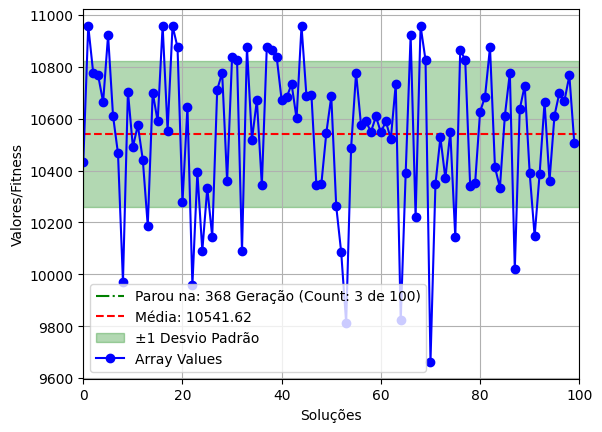

In [ ]:
import matplotlib.pyplot as plt
import statistics

# Rodando as 100 vezes o algoritmo, com os mesmos itens
i=0
global_solutions = []
global_fitness = []
gen_stop = []
while i < 100:
  best_solution, best_fitness = genetic_algorithm(population_size, generations, mutation_rate)
  global_solutions.append(best_solution)
  global_fitness.append(best_fitness)
  i += 1

print("Best solution:", max(global_fitness))
print("Best fitness:", best_fitness)

# Calculando a média de fitness e a moda da geração em que chegou no platô
mode_value_gen = statistics.mode(gen_stop)
mean_value_fitness = sum(global_fitness) / len(global_fitness)

# Desvio Padrão
std_dev = statistics.stdev(global_fitness)

print(f"Desvio padrão: {std_dev}")


mode_count = gen_stop.count(mode_value_gen)
mode_text = f'Parou na: {mode_value_gen} Geração (Count: {mode_count} de 100)'

plt.axvline(x=mode_value_gen, color='green', linestyle='-.', label=mode_text)
plt.axhline(y=mean_value_fitness, color='red', linestyle='--', label=f'Média: {mean_value_fitness:.2f}')
plt.axhspan(mean_value_fitness - std_dev, mean_value_fitness + std_dev, alpha=0.3, color='green', label='±1 Desvio Padrão')

plt.plot(global_fitness, marker='o', linestyle='-', color='blue', label='Array Values')
plt.xlim(0, 100)
plt.xlabel('Soluções')
plt.ylabel('Valores/Fitness')
plt.title('')
plt.legend()
plt.grid(True)
plt.savefig('plot_with_mean_std_dev.png', dpi=300, bbox_inches='tight')
plt.show()